<a href="https://colab.research.google.com/github/Randhir123/quant/blob/main/Multivariate_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multivariate RNNs**

## **1. Introduction: S&P500 index and the VIX**

It is now time to augment our deep RNNs to consider more than one series of inputs. In this lesson we revisit the market timing example, but we will now predict stock prices using past information (prices) about the security as well as a leading indicator variable. Specifically, we will try to predict the prices of an Exchange Traded Fund (ETF) that replicates the composition and behavior of the S&P500 index in the U.S., the famous 'SPY'. And we will use for that not only past prices of SPY, but also the prices (levels) of a leading indicator of S&P500 index: the VIX index.

The VIX is a volatility index of the S&P500 market index. It is constructed using the implied volatility from a portfolio of 30-day constant-maturity options on S&P500 index. Since we all well know at this point, the fact that VIX index is constructed using options-implied volatility information means that it reflects investor's expectations on the underlying asset, the S&P500 index (Ticker symbol 'SPX'). More information on the VIX, and how it can be useful in the next few bullet points (please note these materials are only informative, not investment recommendation!):

  - More information about the VIX index by the 'creators', Chicago Board Options Exchange (CBOE): https://www.cboe.com/tradable_products/vix/faqs/

  - How investors & traders use the VIX: https://optionshawk.com/how-to-use-the-vix-as-a-market-signal/

  - A web were you can consult the 'term structure' of Future contracts over VIX with different maturities: http://vixcentral.com/

  - How to interpret the VIX term structure: https://www.projectfinance.com/vix-term-structure/

  - An interesting paper on how to use VIX term structure to predict recessions: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3943982

  - A great academic paper on how VIX term structure predicts risk premia: https://www.cambridge.org/core/services/aop-cambridge-core/content/view/56572D1F060448571BD8F597C732D9C3/S0022109017000825a.pdf/risk_premia_and_the_vix_term_structure.pdf

  - On using VIX in investing under a formal, systematic approach: https://joi.pm-research.com/content/23/3/130.short




\
When you come to think about it, if VIX really works as a powerful leading indicator of SPX, adding it as an input to our RNN prediction problem should be like 'cheating'. If we think about another type of prediction task suited for RNNs, such as language models, it would be like asking the model to predict how a sentence would end knowing what are the next few words. It should simplify the prediction task a lot!


**Spoiler alert!** It will not. Or, at least, it will not necessarily do it. For example, what if investors already looked at VIX prices to decide on their trading in the S&P500? In that case, it is likely that adding the VIX to our input matrix set could be even redundant, as this information is already incorporated into prices themselves.

Of course, it may be the case that investors (or at least some of them) are oblivious to information contained in VIX. For starters, it is likely that investors trading the S&P500 index and its components are inherently different from those trading options on the SPX. These differences can arise not only in terms of how informed are each of these guys, but also their investment horizon, risk-aversion, ... All in all, these features (and others, like limits to arbitrage) cast doubts (at least ex-ante) on whether S&P500 incorporates data on VIX and the potential predictive power of VIX as a leading indicator.

So... let's resolve this question!


## **2. Data gathering**

As usual, we will start with the data gathering process. Note how in this case we do not only gather daily stock prices from our S&P500 index ETF, SPY, from Yahoo! finance, but also on the daily prices (levels) of VIX. We will be working, as usual, with daily prices and trying to predict what is the next price that SPY will take.  

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

df = yf.download(("SPY", "^VIX"), start="2010-01-01", end="2022-04-11")
del df["Volume"]
del df["Adj Close"]
del df["High"]
del df["Low"]
del df["Open"]
df["Output"] = df["Close"]["SPY"].shift(-1)
df.reset_index(inplace=True)

[*********************100%%**********************]  2 of 2 completed


In [2]:
print("Length of data frame: ", len(df))
df.head()

Length of data frame:  3089


Price        Date       Close                 Output
Ticker                    SPY       ^VIX            
0      2010-01-04  113.330002  20.040001  113.629997
1      2010-01-05  113.629997  19.350000  113.709999
2      2010-01-06  113.709999  19.160000  114.190002
3      2010-01-07  114.190002  19.059999  114.570000
4      2010-01-08  114.570000  18.129999  114.730003

## **3. Validation, train and test sample definition**

Next, we proceed to define our training, test, and validation sets. Note that we will train using the 98% of the sample. The validation set will be 20% of the training test. We also need to define a 'window' of observations that we are going to take as a sequence input to our network. In this case we choose a window of 20, which means that the last 20 prices (observations) will be incorporated into the sequence of inputs for the network. In this case this means that we will have a sequence of 20 SPY prices, as well as 20 VIX prices that will be part of the training at each $t$.

In [3]:
# First, we deal with the definition of the training, test, and validations sets sizes
val_split = 0.2
train_split = 0.98
train_size = int(len(df) * train_split)
val_size = int(train_size * val_split)
test_size = int(len(df) - train_size)

window_size = 20  # How many daily prices do I want to incorporate in the input sequence for the network?

ts = test_size
split_time = len(df) - ts
test_time = df.iloc[split_time + window_size :, 0:1].values

# Second, we actually define the input matrix for train (X_train) and test (X_test), as well as the output vector (y_train and y_test).
Xdf, ydf = (
    df.iloc[:, 1:3],
    df.iloc[:, -1],
)  # Note how we choose close prices from both SPY and VIX in the X matrix
X = Xdf.astype("float32")
y = ydf.astype("float32")

y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time:]

n_features = X_train_set.shape[1]

# Third, we proceed with scaling inputs to the model.
scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

mean_ret = np.mean(y_train_set)

scaler_output = MinMaxScaler(feature_range=(-1, 1))
y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
y_test_set = y_test_set.values.reshape(len(y_test_set), 1)
scaler_output.fit(y_train_set)
y_train_set_scaled = scaler_output.transform(y_train_set)


# # Lastly, because we want a time series with up to 20 (window_size) past observations, we need to append these observations into our matrix/vectors!
training_time = df.iloc[:split_time, 0:1].values

X_train = []
y_train = []

for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

X_test = []
y_test = y_test_set

for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])


X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape)
print(y_test.shape)
print(n_features)

(3007, 20, 2)
(3007, 1)
(42, 20, 2)
(62, 1)
2


## **4. Defining the RNN model**

Once we have pre-processed the input and output data of our network, let's build it!

Our network architecture will be identical to the one from Lesson 2. We consider a simple RNN 5 hidden layers (4 simple RNN layers + 1 final dense layer). Each of the RNN layers will have 50 neurons. We apply a Dropout of 20% after each of the RNN layers. Finally, before the single-unit final output layer, we will apply a dense layer with 10 neurons.

As we already mentioned, this choice of architecture is as good as random. We leave to you to play around with the architecture and check how predictions vary.

Remember that a good resource to have nearby when implementing any Deep Neural Network is the TensorFlow/Keras documentation: https://www.tensorflow.org/guide/keras/rnn?hl=en

In [4]:
import tensorflow as tf

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.SimpleRNN(
            50, return_sequences=True, input_shape=(X_train.shape[1], n_features)
        ),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.SimpleRNN(50, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.SimpleRNN(50, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.SimpleRNN(50, return_sequences=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10),
        tf.keras.layers.Dense(1),
    ]
)

Let's now check how our model looks like:

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 50)            2650      
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 20, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 20, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5

Now, the number of parameters in the first layer of the model changes a little bit. Where does the 2,650 come from?

 Well, 50x50 (neurons in the layer) + 50x2 (neurons times number of model features) + 50x1 (bias terms) = 2,650

Note how the total model parameters is now 18,321. Only 50 more (because there is 1 more input feature) than the similar model from Lesson 2. Finally, note how the only impact on model parameters from incorporating 1 more feature comes in the first layer of the model. After that, there is no increase in the trainable parameters resulting from considering more input features. This is also important to take into account when considering how the 'size' of the model may impact the performance of backprop and gradient descent algorithm: It is much more about the 'length' of the input sequence than the number of input features themselves!

## **5. Model training**

Now, we can proceed with model training.

In [6]:
from keras.callbacks import EarlyStopping

hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=10, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=64,
    verbose=1,
    callbacks=[es],
)

Epoch 1/500
38/38 [==============================] - 5s 40ms/step - loss: 0.7353 - val_loss: 0.2678
Epoch 2/500
38/38 [==============================] - 1s 25ms/step - loss: 0.6477 - val_loss: 0.2889
Epoch 3/500
38/38 [==============================] - 1s 35ms/step - loss: 0.5671 - val_loss: 0.3565
Epoch 4/500
38/38 [==============================] - 2s 44ms/step - loss: 0.5454 - val_loss: 0.3570
Epoch 5/500
38/38 [==============================] - 1s 33ms/step - loss: 0.5137 - val_loss: 0.3082
Epoch 6/500
38/38 [==============================] - 1s 25ms/step - loss: 0.4891 - val_loss: 0.2966
Epoch 7/500
38/38 [==============================] - 1s 25ms/step - loss: 0.4688 - val_loss: 0.2598
Epoch 8/500
38/38 [==============================] - 1s 25ms/step - loss: 0.4510 - val_loss: 0.3228
Epoch 9/500
38/38 [==============================] - 1s 26ms/step - loss: 0.4293 - val_loss: 0.2159
Epoch 10/500
38/38 [==============================] - 1s 25ms/step - loss: 0.4109 - val_loss: 0.2032

Then we can make our predictions on the test sample based on the trained model parameters:

In [7]:
prediction = model.predict(X_test)
prediction = scaler_output.inverse_transform(prediction)
prediction = prediction.flatten()

values = np.array(y_test[window_size:])
values = values.flatten()

2/2 [==============================] - 0s 9ms/step


In [8]:
df_predictions = pd.DataFrame(
    {"Date": test_time.flatten(), "Pred RNN": prediction, "values": values}
)
df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%Y-%m-%d")
df_predictions.head()

,Date,Pred RNN,values
0,2022-02-09,444.985504,449.320007
1,2022-02-10,445.749176,440.459991
2,2022-02-11,446.833496,439.019989
3,2022-02-14,447.369568,446.100006
4,2022-02-15,444.939575,446.600006


And visualize it,

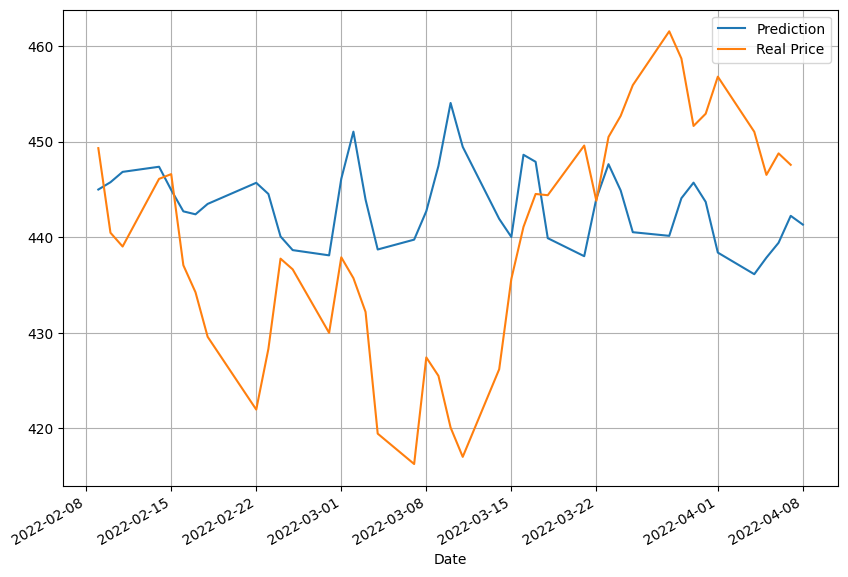

In [9]:
import matplotlib.pyplot as plt

plt_1 = plt.figure(figsize=(10, 7))
ax = plt.gca()
df_predictions.plot(x="Date", y="Pred RNN", label="Prediction", ax=ax)
df_predictions.plot(x="Date", y="values", label="Real Price", ax=ax)
plt.grid()
plt.show()

As you can see (and please remember that we have not fixed the random seed so you may obtain different outcomes every time you train the model), the VIX does not really improve the predictive performance of the model by a lot (sometimes it's even making it worse!).

Can you think of ways to augment and improve this model? Well, one option may be using other types of 'leading variables'. For example, some variables used in practice for this are: prices of oil futures, manufacturing PMI in the U.S., agricultural production, ...

But we would usually not like a model that uses too many inputs because it will probably lead not only to increase training time and computational resources, but also to a lower degree of understanding regarding the interplay between the different features. Bottom line, it is important to understand the basics of how models work before we start adding inputs!

## **6. A final note on NLP**

One of the main uses of RNNs is Natural Language Processing (NLP), which is a fascinating area. Sadly, there are, yet, not so many applications of NLP to financial market problems, which is why we have not focused on language models in this module.

In the book by Zhang. et. al. (2022) that we have been using as a reference for the whole course you have much more information on NLP models in case you are interested. Specifically, Chapters 15 and 16 deal with the pre-training and direct applications of NLP models in practice. Note that RNNs are just one part of NLP models, but probably the ones that make more sense when focusing on areas such as speech recognition.

Here you can have more info for the use of NLP in finance:

- A few examples of finance-related applications of NLP: https://softengi.com/blog/nlp-use-cases-in-finance/

- One important application of NLP in finance is sentiment analysis. Here you have a quick review of it: https://research.aimultiple.com/sentiment-analysis-stock-market/

- A paper by Mittal and Goel (Standford) that uses Twitter sentiment analysis for stock price prediction: http://cs229.stanford.edu/proj2011/GoelMittal-StockMarketPredictionUsingTwitterSentimentAnalysis.pdf


These are just some examples to 'whet your appetite'. Surely you can find many more!


## **7. Conclusion**

In this lesson, we have dealt with multivariate RNNs. This means that we have used several input features into a recursive neural network model. So far, we have not obtained great results, though. But we have used a very tiny portion of all the available tools in deep learning and recursive networks.